In [1]:
import sys
if 'google.colab' in sys.modules:  # colab特有の処理_2回目以降
  # Google Driveのマウント
  from google.colab import drive
  drive.mount('/content/drive')

  # ライブラリのパス指定
  sys.path.append('/content/drive/MyDrive/Colab_Files/kaggle/commonlit/XX_modules')


Mounted at /content/drive


In [2]:
!nvidia-smi

Sat Jul 31 15:28:28 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P0    39W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# データセットをDriveから取得
!mkdir -p 'input'
!mkdir -p 'clrp-pre-trained'

!cp -r '/content/drive/MyDrive/Colab_Files/kaggle/commonlit/00_input/commonlitreadabilityprize/' '/content/input'
!cp -r '/content/drive/MyDrive/Colab_Files/kaggle/commonlit/97_pre_trained/clrp_pretrained_manish_epoch5/pre-trained-roberta/clrp_roberta_large/' '/content/clrp-pre-trained'

In [3]:
from pathlib import Path

# input
if 'kaggle_web_client' in sys.modules:  # kaggle環境
    DATA_DIR = Path('../input/commonlitreadabilityprize/')

elif 'google.colab' in sys.modules: # Colab環境
    DATA_DIR = Path('/content/input/commonlitreadabilityprize')

else:
    DATA_DIR = Path('../00_input/commonlitreadabilityprize/')

In [4]:
from pathlib import Path

# tokenizer
if 'kaggle_web_client' in sys.modules:  # kaggle環境
    TOKENIZER_DIR = '../input/roberta-transformers-pytorch/roberta-large'
elif 'google.colab' in sys.modules: # Colab環境
    TOKENIZER_DIR = '/content/clrp-pre-trained/clrp_roberta_large' # 仮で、毎回DLする想定のモデル名を指定。あとで変更予定。
else:
    TOKENIZER_DIR = 'roberta-large'

In [5]:
from pathlib import Path

# pre-trained model
if 'kaggle_web_client' in sys.modules:  # kaggle環境
    PRE_TRAINED_MODEL_DIR = '../input/roberta-transformers-pytorch/roberta-large'
elif 'google.colab' in sys.modules: # Colab環境
    PRE_TRAINED_MODEL_DIR = '/content/clrp-pre-trained/clrp_roberta_large' # 仮で、毎回DLする想定のモデル名を指定。あとで変更予定。
else:
    PRE_TRAINED_MODEL_DIR = 'roberta-large'

In [6]:
UPLOAD_DIR = Path('/content/model')
EX_NO = '057-051-train-08-02'  # 実験番号などを入れる、folderのpathにする
USERID = 'calpis10000'

In [7]:
import subprocess
import shlex

def gpuinfo():
    """
    Returns size of total GPU RAM and used GPU RAM.

    Parameters
    ----------
    None

    Returns
    -------
    info : dict
        Total GPU RAM in integer for key 'total_MiB'.
        Used GPU RAM in integer for key 'used_MiB'.
    """

    command = 'nvidia-smi -q -d MEMORY | sed -n "/FB Memory Usage/,/Free/p" | sed -e "1d" -e "4d" -e "s/ MiB//g" | cut -d ":" -f 2 | cut -c2-'
    commands = [shlex.split(part) for part in command.split(' | ')]
    for i, cmd in enumerate(commands):
        if i==0:
            res = subprocess.Popen(cmd, stdout=subprocess.PIPE)
        else:
            res = subprocess.Popen(cmd, stdin=res.stdout, stdout=subprocess.PIPE)
    total, used = map(int, res.communicate()[0].decode('utf-8').strip().split('\n'))
    info = {'total_MiB':total, 'used_MiB':used}
    return info


# Overview
This nb is based on copy from https://www.kaggle.com/andretugan/lightweight-roberta-solution-in-pytorch .

Acknowledgments(from base nb): 
some ideas were taken from kernels by [Torch](https://www.kaggle.com/rhtsingh) and [Maunish](https://www.kaggle.com/maunish).

In [8]:
import os
import math
import random
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from transformers import AdamW # optimizer
from transformers import AutoTokenizer
from transformers import AutoModel
from transformers import AutoConfig
from transformers import get_cosine_schedule_with_warmup # scheduler
from pytorch_memlab import profile
import pytorch_memlab
from pytorch_memlab import MemReporter

from sklearn.model_selection import KFold, StratifiedKFold

import gc
gc.enable()

In [9]:
NUM_FOLDS = 5 # K Fold
NUM_EPOCHS = 6 # Epochs
BATCH_SIZE = 8 # Batch Size
MAX_LEN = 248 # ベクトル長
EVAL_SCHEDULE = [(0.55, 64), (-1., 32)] # schedulerの何らかの設定？
ROBERTA_PATH = PRE_TRAINED_MODEL_DIR # roberta pre-trainedモデル(モデルとして指定)
TOKENIZER_PATH = TOKENIZER_DIR # roberta pre-trainedモデル(Tokenizerとして指定)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu" # cudaがなければcpuを使えばいいじゃない

In [10]:
def set_random_seed(random_seed):
    random.seed(random_seed)
    np.random.seed(random_seed)
    os.environ["PYTHONHASHSEED"] = str(random_seed)

    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)

    torch.backends.cudnn.deterministic = True# cudnnによる最適化で結果が変わらないためのおまじない 

In [11]:
# read train_df(kfold)
train_kf_df = pd.read_csv(DATA_DIR/"train_kfold.csv")

In [12]:
# tokenizerを指定
tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_PATH)

# Dataset

In [13]:
train_kf_df.head()

,id,url_legal,license,excerpt,target,standard_error,kfold,bins_tg,bins_std,bins
0,822c5d421,https://www.commonlit.org/texts/the-1972-andes...,CC BY-NC-SA 2.0,Search parties from three countries looked for...,-0.279952,0.465558,4,7,2,72
1,fa84dbf46,NaN,NaN,With trembling hands the lad took the shavings...,0.088148,0.499267,1,8,3,83
2,cf48c7441,NaN,NaN,Rhea which is also known under the name of ram...,-1.198192,0.472505,0,5,2,52
3,d9eb41f75,NaN,NaN,Ditson had fawned around Browning a great deal...,-1.199957,0.468701,0,5,2,52
4,bd3d86f22,NaN,NaN,"The Old Lady lived ""away back at the old Lloyd...",-0.956118,0.503286,3,6,4,64


In [14]:
train_kf_df['target']

0      -0.279952
1       0.088148
2      -1.198192
3      -1.199957
4      -0.956118
          ...   
2828   -0.528836
2829   -1.188881
2830   -3.164808
2831   -1.979798
2832   -0.422689
Name: target, Length: 2833, dtype: float64

In [15]:
# 前処理用
import string
import re
# ローカルの場合、stopwordsをダウンロード
import nltk
if 'kaggle_web_client' in sys.modules:  # kaggle環境
    pass
else:
    import nltk
    nltk.download('stopwords')
    nltk.download('averaged_perceptron_tagger')
    os.listdir(os.path.expanduser('~/nltk_data/corpora/stopwords/'))

# テキスト前処理
# https://www.kaggle.com/alaasedeeq/commonlit-readability-eda

#filtering the unwanted symbols, spaces, ....etc
to_replace_by_space = re.compile('[/(){}\[\]|@,;]')
punctuation = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
bad_symbols = re.compile('[^0-9a-z #+_]')
stopwords = set(nltk.corpus.stopwords.words('english'))

def text_prepare(text):
    '''
    text: a string
    returna modified version of the string
    '''
    text = text.lower() # lowercase text
    text = re.sub(punctuation, '',text)
    text = re.sub(to_replace_by_space, " ", text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = re.sub(bad_symbols, "", text)         # delete symbols which are in BAD_SYMBOLS_RE from text
    text = " ".join([word for word in text.split(" ") if word not in stopwords]) # delete stopwords from text
    text = re.sub(' +', ' ', text)
    return text

def text_normalization(s:pd.Series):
    x = s.apply(text_prepare)
    return x

# Counterオブジェクトを取得
def get_counter(text:str):
    text_list = [wrd for wrd in text.split(" ") if wrd not in ('', '\n')]
    counter = collections.Counter(text_list)
    return counter


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [16]:
def separete_target_sign_abs(sr_: pd.Series()):
  return [sr_.map(np.sign), sr_.map(np.abs)]

class LitDataset(Dataset):
    def __init__(self, df, inference_only=False):
        super().__init__()

        self.df = df        
        self.inference_only = inference_only # Testデータ用フラグ
        self.text = df.excerpt.tolist() # 分析対象カラムをlistにする。(分かち書きではなく、Seriesをlistへ変換するような処理)
        #self.text = [text.replace("\n", " ") for text in self.text] # 単語単位で分かち書きする場合
        self.text_len = text_normalization(df.excerpt).map(lambda x: [0 if i >= len(x.split(' ')) else len(x.split(' ')[i]) for i in range(132)])

        if not self.inference_only:
            self.target = torch.tensor(df.target.values, dtype=torch.float32) # trainのみ、targetをtensorに変換
            self.standard_error = torch.tensor(df.standard_error.values, dtype=torch.float32) 

            target_sep = separete_target_sign_abs(df.target)
            self.target_sign = torch.tensor(target_sep[0].map({-1:0, 0:0, 1:1}).values, dtype=torch.float32) # 値を変換: -1 or 1 -> 0 or 1 
            self.target_abs = torch.tensor(target_sep[1].values, dtype=torch.float32)

        self.encoded = tokenizer.batch_encode_plus( # textをtokenize
            self.text,
            padding = 'max_length',            
            max_length = MAX_LEN,
            truncation = True, # 最大長を超える文字は切り捨て
            return_attention_mask=True
        )        
 
    def __len__(self):
        return len(self.df)

    
    def __getitem__(self, index): # 変換結果を返す
        input_ids = torch.tensor(self.encoded['input_ids'][index])
        attention_mask = torch.tensor(self.encoded['attention_mask'][index])
        input_len = torch.tensor(self.text_len.iloc[index], dtype=torch.float32)

        if self.inference_only:
            return (input_ids, attention_mask, input_len)            
        else:
            target_sign = self.target_sign[index]
            #target_abs = self.target_abs[index]
            target = self.target[index]
            standard_error = self.standard_error[index]
            return (input_ids, attention_mask, input_len, target_sign, target, standard_error)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


In [17]:
trial_df = LitDataset(train_kf_df)


In [18]:
trial_df[0]

(tensor([    0, 39954,  1799,    31,   130,   749,  1415,    13,     5,  1716,
          3286,     4,   635,     6,   187,     5,  3286,    21,  1104,     6,
            24, 25630,    11,    19,     5,  1958,     6,   442,    24,  8077,
         20731,    31,     5,  6360,     4,    20,  2557,  1707,    21,  9491,
            71,   799,   360,     4,    20,  7149,     9,     5,  2058,    56,
           303,    10,   650, 45573,  3188,    15,     5,  3286,     8,  5470,
         17006,     6,    65,     9,     5,  7149,     6,    78,  1317,     5,
           340,    14,     5,  1707,    21,  9491,    15,    49,   365,   212,
           183,    15,     5,  6485,     4, 50118, 39986,  1576,     5,   340,
             6,     5,  7149,   880,     7, 18769,     8, 10745,    93,    70,
          4682, 28377,   139, 24947,  1725,     6,    54,  1415, 27035,    62,
             5,  9787,    61,  1458,     7,     5,  3072,     4,    22, 13368,
          2786,    60,    37, 15355,     6,    22,  

# Model
The model is inspired by the one from [Maunish](https://www.kaggle.com/maunish/clrp-roberta-svm).

In [19]:
class LitModel(nn.Module):
    def __init__(self):
        super().__init__()

        config = AutoConfig.from_pretrained(ROBERTA_PATH) # pretrainedからconfigを読み込み
        config.update({"output_hidden_states":True, # config更新: embedding層を抽出
                       "hidden_dropout_prob": 0.0, # config更新: dropoutしない
                       "layer_norm_eps": 1e-7}) # config更新: layer normalizationのepsilon                      
        
        self.roberta = AutoModel.from_pretrained(ROBERTA_PATH, config=config) # cpuで処理する
            
        self.attention = nn.Sequential(# attentionレイヤー            
            nn.Linear(config.hidden_size, 512),      
            nn.Tanh(),                       
            nn.Linear(512, 1),
            nn.Softmax(dim=1)
        )

        self.mlm_layers = nn.Sequential(
            nn.Linear(132, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
        )

        self.regressor = nn.Sequential( # target、stderror                  
            nn.Linear(config.hidden_size + 64, 2)                        
        )

        self.bin_class = nn.Sequential( # target_sign
            nn.Linear(config.hidden_size + 64, 1),
            nn.Dropout(p=0.2),
            nn.Sigmoid()                       
        )


    def forward(self, input_ids, attention_mask, input_len):
        roberta_output = self.roberta(input_ids=input_ids, # robertaに入力データを流し、出力としてrobertaモデル(layerの複合体)を得る
                                      attention_mask=attention_mask)     
        # attention_pooling
        last_hidden_state = roberta_output.hidden_states[-1] # robertaモデルの最後のlayerを得る
        weights = self.attention(last_hidden_state) # robertaの最後のlayerをattentionへ入力し、出力として重みを得る                
        context_vector = torch.sum(weights * last_hidden_state, dim=1) # 重み×最後の層を足し合わせて文書ベクトルとする。

        # word_length_conv1d
        #input_chnl = input_len.unsqueeze(1)
        #conv1_layers = self.conv1_layers(input_chnl)
        #conv1_layers_v = conv1_layers.view(conv1_layers.size(0),-1)

        # word_length_mlm
        mlm_layers = self.mlm_layers(input_len)

        # https://www.kaggle.com/rhtsingh/utilizing-transformer-representations-efficiently
        # last_hidden_state = roberta_output[0]
        # input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        # sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        # sum_mask = input_mask_expanded.sum(1)
        # sum_mask = torch.clamp(sum_mask, min=1e-9)
        # mean_embeddings = sum_embeddings / sum_mask

        # concat_embeddings
        cat_embeddings = torch.cat([context_vector, mlm_layers], dim=1)
        regressor = self.regressor(cat_embeddings)
        bin_class = self.bin_class(cat_embeddings)
        return [regressor, bin_class]
        
        # Now we reduce the context vector to the prediction score.
        #return self.regressor(mean_embeddings) # 文書ベクトルを線形層に入力し、targetを出力する

In [20]:
def eval_mse(model, data_loader):
    """Evaluates the mean squared error of the |model| on |data_loader|"""
    model.eval() # evalモードを選択。Batch Normとかdropoutをしなくなる           
    bce_sign = 0
    mse_mean_sum = 0
    mse_std_sum = 0

    with torch.no_grad(): # 勾配の計算をしない(予測のみ行う)
        for batch_num, (input_ids, attention_mask, input_len, target_sign, target, standard_error) in enumerate(data_loader): # data_loaderからinput, attentin_mask, targetをbatchごとに取り出す
            input_ids = input_ids.to(DEVICE)   
            attention_mask = attention_mask.to(DEVICE)  
            input_len = input_len.to(DEVICE) 
            target_sign = target_sign.to(DEVICE)  
            target = target.to(DEVICE)
            standard_error = standard_error.to(DEVICE)
            
            output = model(input_ids, attention_mask, input_len) # 取得した値をモデルへ入力し、出力として予測値を得る。

            bce_sign += nn.BCELoss(reduction="sum")(output[1].flatten(), target_sign).item() # +-のBCE
            mse_mean_sum += nn.MSELoss(reduction="sum")(output[0][:,0].flatten(), target).item() # 誤差の合計を得る(Batchごとに計算した誤差を足し上げる)
            mse_std_sum += nn.MSELoss(reduction="sum")(output[0][:,1].flatten(), target).item() # 誤差の合計を得る(Batchごとに計算した誤差を足し上げる)


    del input_ids
    del attention_mask

    bce_sign_result = bce_sign / len(data_loader.dataset)
    mse_mean_result = mse_mean_sum / len(data_loader.dataset)
    mse_std_result = mse_std_sum / len(data_loader.dataset)

    return bce_sign_result, mse_mean_result, mse_std_result

In [32]:
# 推論結果を返す
def predict(model, data_loader):
    """Returns an np.array with predictions of the |model| on |data_loader|"""
    model.eval() # evalモード(dropout, batch_normしない)

    result = np.zeros(len(data_loader.dataset)) # 結果をdataset長のzero配列として用意
    index = 0
    
    with torch.no_grad(): # 勾配の計算をしないblock(inputすると、現状の重みによる推論結果を返す)
        for batch_num, (input_ids, attention_mask, input_len) in enumerate(data_loader): # data_loaderからbatchごとにinputを得る
            input_ids = input_ids.to(DEVICE)
            attention_mask = attention_mask.to(DEVICE)
            input_len = input_len.to(DEVICE)
                        
            output = model(input_ids, attention_mask, input_len) # modelにinputを入力し、予測結果を得る。
            output_target = output[0][:,0]

            result[index : index + output_target.shape[0]] = output_target.flatten().to("cpu") # result[index ~ predの長さ]へ、予測結果を格納
            index += output_target.shape[0] # indexを更新

    return result # 全batchで推論が終わったら、結果を返す

In [22]:
# 学習
def train(model, # モデル
          model_path, # モデルのアウトプット先
          train_loader, # train-setのdata_loader
          val_loader, # valid-setのdata_loader
          optimizer, # optimizer
          scheduler=None, # scheduler, デフォルトはNone
          num_epochs=NUM_EPOCHS # epoch数、notebook冒頭で指定した値
         ):    
    
    best_val_rmse = None
    best_val_sign_bce = None
    best_epoch = 0
    step = 0
    last_eval_step = 0
    eval_period = EVAL_SCHEDULE[0][1] # eval期間(って何？) 冒頭で決めたEVAL_SCHEDULEの最初のtupleの[1]を取得

    start = time.time() # 時間計測用

    for epoch in range(num_epochs): # 指定したEpoch数だけ繰り返し
        val_rmse = None         

        for batch_num, (input_ids, attention_mask, input_len, target_sign, target, standard_error) in enumerate(train_loader): # train_loaderからinput, targetを取得
            input_ids = input_ids.to(DEVICE) # inputをDEVICEへ突っ込む
            attention_mask = attention_mask.to(DEVICE)   
            input_len = input_len.to(DEVICE)
            target_sign = target_sign.to(DEVICE)
            target = target.to(DEVICE)
            standard_error = standard_error.to(DEVICE)

            optimizer.zero_grad() # 勾配を初期化            
            model.train() # 学習モード開始

            # https://www.kaggle.com/c/commonlitreadabilityprize/discussion/239421
            output = model(input_ids, attention_mask, input_len) # input,attention_maskを入力し、予測結果を得る

            p = torch.distributions.Normal(output[0][:,0], torch.sqrt(output[0][:,1]**2))
            q = torch.distributions.Normal(target, standard_error)
            kl_vector = torch.distributions.kl_divergence(p, q)

            loss1 = nn.BCELoss(reduction="mean")(output[1].flatten(), target_sign) # +-のBCE
            loss2 = kl_vector.mean()

            loss1.backward(retain_graph=True) 
            loss2.backward() 
            #loss3.backward()
            optimizer.step() # 重みを更新する

            if scheduler:
                scheduler.step() # schedulerが与えられた場合は、schedulerの学習率更新
            
            if step >= last_eval_step + eval_period: # batchを回すごとにstepを増やしていって、「前回evalしたstep + eval_period(16)」を超えたら実行。
                print(gpuinfo())
                # Evaluate the model on val_loader.
                elapsed_seconds = time.time() - start # 経過時間
                num_steps = step - last_eval_step # 経過ステップ数
                print(f"\n{num_steps} steps took {elapsed_seconds:0.3} seconds")
                last_eval_step = step # 前回stepの更新
                
                # valid-setによるrmse計算
                train_sign_bce = loss1
                train_kldiv = loss2
                
                val_sign_bce, val_mse_mean, val_mse_std = eval_mse(model, val_loader)
                val_rmse_mean = math.sqrt(val_mse_mean)                            
                val_rmse_std = math.sqrt(val_mse_std)                            

                print(f"Epoch: {epoch} batch_num: {batch_num}")
                print(f"train_kldiv: {train_kldiv:0.4}",
                      f"train_sign_bce: {train_sign_bce:0.4}"
                      )
                print(f"val_rmse_mean: {val_rmse_mean:0.4}",
                      f"val_sign_bce: {val_sign_bce:0.4}",
                      f"val_rmse_std: {val_rmse_std:0.4}"
                      )

                for rmse, period in EVAL_SCHEDULE: # eval_periodをvalid-rmseで切り替える処理
                    if val_rmse_mean >= rmse: # valid rmseをEVAL_SCHEDULEと比較し、0項 > valid rmseとなるまで回す : EVAL_SCHEDULE = [(0.50, 16), (0.49, 8), (0.48, 4), (0.47, 2), (-1., 1)]
                        eval_period = period # eval_periodを更新
                        break                               

                if not best_val_rmse or val_rmse_mean < best_val_rmse: # 初回(best_val_rmse==None), またはbest_val_rmseを更新したらモデルを保存する
                    best_val_rmse = val_rmse_mean
                    best_epoch = epoch
                    torch.save(model.state_dict(), model_path) # 最高の自分を保存
                    print(f"New best_val_rmse: {best_val_rmse:0.4}")
                else:       
                    print(f"Still best_val_rmse: {best_val_rmse:0.4}", # 更新されない場合は、元のスコアを表示
                          f"(from epoch {best_epoch})")      

                if not best_val_sign_bce or val_sign_bce < best_val_sign_bce: # 初回(best_val_rmse==None), またはbest_val_rmseを更新したらモデルを保存する
                    best_val_sign_bce = val_sign_bce
                    best_epoch_sign = epoch
                    torch.save(model.state_dict(), f'sign_{model_path}') # 最高の自分を保存_プラマイ
                    print(f"New best_val_sign_bce: {best_val_sign_bce:0.4}")
                else:       
                    print(f"Still best_val_sign_bce: {best_val_sign_bce:0.4}", # 更新されない場合は、元のスコアを表示
                          f"(from epoch {best_epoch_sign})")      

                start = time.time()
            
            # batchごとにメモリ解放
            del input_ids
            del attention_mask
            torch.cuda.empty_cache()                                            
            step += 1
    
    return best_val_rmse

In [23]:
# optimizerの作成
def create_optimizer(model):
    parameters = []

    named_parameters = list(model.named_parameters()) # モデルパラメータの取得
    roberta_parameters = list(model.roberta.named_parameters())[:-2] # パラメータをroberta用、attention用、regressor用に格納。(直接引っ張ってくる形式に変更)

    attention_parameters = list(model.attention.named_parameters())
    attention_group = [{'params': params, 'lr': 2e-5} for (name, params) in attention_parameters] # attention用パラメータをリストとして取得
    parameters += attention_group

    #norm_parameters = list(model.layer_norm.named_parameters())
    #norm_group = [{'params': params, 'lr': 2e-5} for (name, params) in norm_parameters]
    #parameters += norm_group

    mlm_parameters = list(model.mlm_layers.named_parameters())
    mlm_group = [{'params': params, 'lr': 2e-5} for (name, params) in mlm_parameters] # reg用パラメータをリストとして取得
    parameters += mlm_group

    regressor_parameters = list(model.regressor.named_parameters())
    regressor_group = [{'params': params, 'lr': 2e-5} for (name, params) in regressor_parameters] # reg用パラメータをリストとして取得
    parameters += regressor_group

    bin_class_parameters = list(model.bin_class.named_parameters())
    bin_class_group = [{'params': params, 'lr': 2e-5} for (name, params) in bin_class_parameters] # reg用パラメータをリストとして取得
    parameters += bin_class_group


    for layer_num, (name, params) in enumerate(roberta_parameters): # レイヤーごとにname, paramsを取得していろんな処理
        weight_decay = 0.0 if "bias" in name else 0.01

        lr = 8e-6

        if layer_num >= 69:        
            lr = 2e-5

        if layer_num >= 133:
            lr = 4e-5

        parameters.append({"params": params,
                           "weight_decay": weight_decay,
                           "lr": lr})

    return AdamW(parameters) # 最終的に、AdamWにパラメータを入力する。


In [24]:
def train_and_save_model(train_indices, val_indices, model_path):
    train_dataset = LitDataset(train_kf_df.loc[train_indices]) # train, validのDataset
    val_dataset = LitDataset(train_kf_df.loc[val_indices])
        
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                              drop_last=True, shuffle=True, num_workers=2) # train, validのDataLoader
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE,
                            drop_last=False, shuffle=False, num_workers=2)    

    model = LitModel().to(DEVICE) # modelをDEVICEへぶち込む
    optimizer = create_optimizer(model) # optimizerをモデルから作成
    scheduler = get_cosine_schedule_with_warmup( # schedulerを作成
        optimizer,
        num_training_steps=NUM_EPOCHS * len(train_loader),
        num_warmup_steps=50)    
    rmse = train(model, model_path, train_loader, val_loader, optimizer, scheduler=scheduler)

    del train_dataset
    del val_dataset
    del train_loader
    del val_loader
    del model
    del optimizer
    del scheduler
    gc.collect() 
    torch.cuda.empty_cache()
    return rmse

In [26]:
# 実行処理。 KFold & 学習
SEED = 1000
list_val_rmse = []

for fold in sorted(train_kf_df['kfold'].unique()):
    if fold > 100: 
      pass
    else:
      print(f"\nFold {fold + 1}/{NUM_FOLDS}")
      print(gpuinfo())
      model_path = f"model_{fold + 1}.pth" # model_fold数_.pth
      set_random_seed(SEED + fold) # SEEDはfold別に変わるようにする

      train_indices = (train_kf_df['kfold'] != fold)
      val_indices = (train_kf_df['kfold'] == fold)
      list_val_rmse.append(train_and_save_model(train_indices, val_indices, model_path))
      print("\nPerformance estimates:")
      print(list_val_rmse)
      print("Mean:", np.array(list_val_rmse).mean())
      print(gpuinfo())


Fold 1/5
{'total_MiB': 16280, 'used_MiB': 2}


Some weights of the model checkpoint at /content/clrp-pre-trained/clrp_roberta_large were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at /content/clrp-pre-trained/clrp_roberta_large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN thi

{'total_MiB': 16280, 'used_MiB': 12833}

64 steps took 89.5 seconds
Epoch: 0 batch_num: 64
train_kldiv: 1.324 train_sign_bce: 0.7035
val_rmse_mean: 0.6829 val_sign_bce: 0.4758 val_rmse_std: 1.191
New best_val_rmse: 0.6829
New best_val_sign_bce: 0.4758
{'total_MiB': 16280, 'used_MiB': 12833}

64 steps took 88.3 seconds
Epoch: 0 batch_num: 128
train_kldiv: 0.6986 train_sign_bce: 0.4428
val_rmse_mean: 0.6154 val_sign_bce: 0.3956 val_rmse_std: 1.152
New best_val_rmse: 0.6154
New best_val_sign_bce: 0.3956
{'total_MiB': 16280, 'used_MiB': 12833}

64 steps took 88.3 seconds
Epoch: 0 batch_num: 192
train_kldiv: 1.099 train_sign_bce: 0.4608
val_rmse_mean: 0.5911 val_sign_bce: 0.3367 val_rmse_std: 1.147
New best_val_rmse: 0.5911
New best_val_sign_bce: 0.3367
{'total_MiB': 16280, 'used_MiB': 12833}

64 steps took 88.3 seconds
Epoch: 0 batch_num: 256
train_kldiv: 0.4077 train_sign_bce: 0.3464
val_rmse_mean: 0.5883 val_sign_bce: 0.3088 val_rmse_std: 1.135
New best_val_rmse: 0.5883
New best_val_sign

Some weights of the model checkpoint at /content/clrp-pre-trained/clrp_roberta_large were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at /content/clrp-pre-trained/clrp_roberta_large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN thi

{'total_MiB': 16280, 'used_MiB': 12833}

64 steps took 89.9 seconds
Epoch: 0 batch_num: 64
train_kldiv: 0.616 train_sign_bce: 0.3726
val_rmse_mean: 0.659 val_sign_bce: 0.4056 val_rmse_std: 1.707
New best_val_rmse: 0.659
New best_val_sign_bce: 0.4056
{'total_MiB': 16280, 'used_MiB': 12833}

64 steps took 88.3 seconds
Epoch: 0 batch_num: 128
train_kldiv: 1.733 train_sign_bce: 0.4735
val_rmse_mean: 0.8223 val_sign_bce: 0.3665 val_rmse_std: 1.875
Still best_val_rmse: 0.659 (from epoch 0)
New best_val_sign_bce: 0.3665
{'total_MiB': 16280, 'used_MiB': 12833}

64 steps took 88.3 seconds
Epoch: 0 batch_num: 192
train_kldiv: 1.014 train_sign_bce: 0.5161
val_rmse_mean: 0.5496 val_sign_bce: 0.3166 val_rmse_std: 1.832
New best_val_rmse: 0.5496
New best_val_sign_bce: 0.3166
{'total_MiB': 16280, 'used_MiB': 12833}

32 steps took 44.5 seconds
Epoch: 0 batch_num: 224
train_kldiv: 0.5954 train_sign_bce: 0.3531
val_rmse_mean: 0.6417 val_sign_bce: 0.3299 val_rmse_std: 1.775
Still best_val_rmse: 0.5496 (f

Some weights of the model checkpoint at /content/clrp-pre-trained/clrp_roberta_large were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at /content/clrp-pre-trained/clrp_roberta_large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN thi

{'total_MiB': 16280, 'used_MiB': 12833}

64 steps took 89.6 seconds
Epoch: 0 batch_num: 64
train_kldiv: 1.788 train_sign_bce: 0.404
val_rmse_mean: 0.8302 val_sign_bce: 0.4701 val_rmse_std: 1.134
New best_val_rmse: 0.8302
New best_val_sign_bce: 0.4701
{'total_MiB': 16280, 'used_MiB': 12833}

64 steps took 88.4 seconds
Epoch: 0 batch_num: 128
train_kldiv: 0.5832 train_sign_bce: 0.3307
val_rmse_mean: 0.581 val_sign_bce: 0.3475 val_rmse_std: 1.1
New best_val_rmse: 0.581
New best_val_sign_bce: 0.3475
{'total_MiB': 16280, 'used_MiB': 12833}

64 steps took 88.4 seconds
Epoch: 0 batch_num: 192
train_kldiv: 0.4589 train_sign_bce: 0.2847
val_rmse_mean: 0.6411 val_sign_bce: 0.2921 val_rmse_std: 1.119
Still best_val_rmse: 0.581 (from epoch 0)
New best_val_sign_bce: 0.2921
{'total_MiB': 16280, 'used_MiB': 12833}

64 steps took 88.3 seconds
Epoch: 0 batch_num: 256
train_kldiv: 0.4423 train_sign_bce: 0.5518
val_rmse_mean: 0.5423 val_sign_bce: 0.2762 val_rmse_std: 1.084
New best_val_rmse: 0.5423
New b

Some weights of the model checkpoint at /content/clrp-pre-trained/clrp_roberta_large were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at /content/clrp-pre-trained/clrp_roberta_large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN thi

{'total_MiB': 16280, 'used_MiB': 12833}

64 steps took 90.0 seconds
Epoch: 0 batch_num: 64
train_kldiv: 0.2315 train_sign_bce: 0.3979
val_rmse_mean: 0.6581 val_sign_bce: 0.4386 val_rmse_std: 1.153
New best_val_rmse: 0.6581
New best_val_sign_bce: 0.4386
{'total_MiB': 16280, 'used_MiB': 12833}

64 steps took 88.3 seconds
Epoch: 0 batch_num: 128
train_kldiv: 0.8408 train_sign_bce: 0.4571
val_rmse_mean: 0.6823 val_sign_bce: 0.3492 val_rmse_std: 1.114
Still best_val_rmse: 0.6581 (from epoch 0)
New best_val_sign_bce: 0.3492
{'total_MiB': 16280, 'used_MiB': 12833}

64 steps took 88.4 seconds
Epoch: 0 batch_num: 192
train_kldiv: 0.9757 train_sign_bce: 0.3133
val_rmse_mean: 0.5672 val_sign_bce: 0.3473 val_rmse_std: 1.103
New best_val_rmse: 0.5672
New best_val_sign_bce: 0.3473
{'total_MiB': 16280, 'used_MiB': 12833}

64 steps took 88.4 seconds
Epoch: 0 batch_num: 256
train_kldiv: 1.46 train_sign_bce: 0.5281
val_rmse_mean: 0.5999 val_sign_bce: 0.3515 val_rmse_std: 1.121
Still best_val_rmse: 0.567

Some weights of the model checkpoint at /content/clrp-pre-trained/clrp_roberta_large were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at /content/clrp-pre-trained/clrp_roberta_large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN thi

{'total_MiB': 16280, 'used_MiB': 12833}

64 steps took 89.6 seconds
Epoch: 0 batch_num: 64
train_kldiv: 1.057 train_sign_bce: 0.3683
val_rmse_mean: 0.7858 val_sign_bce: 0.4905 val_rmse_std: 2.004
New best_val_rmse: 0.7858
New best_val_sign_bce: 0.4905
{'total_MiB': 16280, 'used_MiB': 12833}

64 steps took 88.4 seconds
Epoch: 0 batch_num: 128
train_kldiv: 0.4852 train_sign_bce: 0.5248
val_rmse_mean: 0.6072 val_sign_bce: 0.4171 val_rmse_std: 1.802
New best_val_rmse: 0.6072
New best_val_sign_bce: 0.4171
{'total_MiB': 16280, 'used_MiB': 12833}

64 steps took 88.4 seconds
Epoch: 0 batch_num: 192
train_kldiv: 0.6815 train_sign_bce: 0.8575
val_rmse_mean: 0.5691 val_sign_bce: 0.386 val_rmse_std: 1.779
New best_val_rmse: 0.5691
New best_val_sign_bce: 0.386
{'total_MiB': 16280, 'used_MiB': 12833}

64 steps took 88.3 seconds
Epoch: 0 batch_num: 256
train_kldiv: 0.9163 train_sign_bce: 0.5769
val_rmse_mean: 0.5496 val_sign_bce: 0.3262 val_rmse_std: 1.796
New best_val_rmse: 0.5496
New best_val_sign_

In [27]:
print(list_val_rmse)

[0.49194433272692994, 0.4688731681524202, 0.4908512233076433, 0.49106495779319725, 0.49085041456158873]


In [28]:
#rep = MemReporter(model)
#rep.report()

In [29]:
#rep = MemReporter(model.roberta)
#rep.report()

In [30]:
#gpuinfo()

In [31]:
#del model
#del optimizer 
#del train_loader
#del val_loader
#del scheduler 
#del list_val_rmse
#del train_indices
#del val_indices
#del tokenizer
#torch.cuda.empty_cache()
#gpuinfo()

# upload models

In [32]:
%cd
!mkdir .kaggle
!mkdir /content/model
!cp /content/drive/MyDrive/Colab_Files/kaggle-api/kaggle.json .kaggle/

!cp -r /content/model_1.pth /content/model/model_1.pth
!cp -r /content/model_2.pth /content/model/model_2.pth
!cp -r /content/model_3.pth /content/model/model_3.pth
!cp -r /content/model_4.pth /content/model/model_4.pth
!cp -r /content/model_5.pth /content/model/model_5.pth
!cp -r /content/sign_model_1.pth /content/model/sign_model_1.pth
!cp -r /content/sign_model_2.pth /content/model/sign_model_2.pth
!cp -r /content/sign_model_3.pth /content/model/sign_model_3.pth
!cp -r /content/sign_model_4.pth /content/model/sign_model_4.pth
!cp -r /content/sign_model_5.pth /content/model/sign_model_5.pth

/root


In [33]:
def dataset_upload():
    import json
    from kaggle.api.kaggle_api_extended import KaggleApi

    id = f'{USERID}/{EX_NO}-02'

    dataset_metadata = {}
    dataset_metadata['id'] = id
    dataset_metadata['licenses'] = [{'name': 'CC0-1.0'}]
    dataset_metadata['title'] = f'{EX_NO}'

    with open(UPLOAD_DIR / 'dataset-metadata.json', 'w') as f:
        json.dump(dataset_metadata, f, indent=4)

    api = KaggleApi()
    api.authenticate()

    # データセットがない場合
    if f'{USERID}/{EX_NO}' not in [str(d) for d in api.dataset_list(user=USERID, search=f'"{EX_NO}"')]:
        api.dataset_create_new(folder=UPLOAD_DIR,
                               convert_to_csv=False,
                               dir_mode='skip')
    # データセットがある場合
    else:
        api.dataset_create_version(folder=UPLOAD_DIR,
                                   version_notes='update',
                                   convert_to_csv=False,
                                   delete_old_versions=True,
                                   dir_mode='skip')
dataset_upload()



  1%|          | 8.67M/1.33G [00:00<00:15, 89.4MB/s]

Starting upload for file sign_model_5.pth


100%|██████████| 1.33G/1.33G [00:13<00:00, 102MB/s]
  1%|          | 6.87M/1.33G [00:00<00:22, 63.3MB/s]

Upload successful: sign_model_5.pth (1GB)
Starting upload for file model_4.pth


100%|██████████| 1.33G/1.33G [00:19<00:00, 71.6MB/s]
  0%|          | 4.68M/1.33G [00:00<00:29, 47.5MB/s]

Upload successful: model_4.pth (1GB)
Starting upload for file sign_model_4.pth


100%|██████████| 1.33G/1.33G [00:12<00:00, 115MB/s]
  1%|          | 6.87M/1.33G [00:00<00:22, 62.9MB/s]

Upload successful: sign_model_4.pth (1GB)
Starting upload for file sign_model_2.pth


100%|██████████| 1.33G/1.33G [00:20<00:00, 70.4MB/s]
  1%|          | 6.87M/1.33G [00:00<00:22, 63.8MB/s]

Upload successful: sign_model_2.pth (1GB)
Starting upload for file model_1.pth


100%|██████████| 1.33G/1.33G [00:19<00:00, 71.2MB/s]
  0%|          | 0.00/1.33G [00:00<?, ?B/s]

Upload successful: model_1.pth (1GB)
Starting upload for file model_5.pth


100%|██████████| 1.33G/1.33G [00:19<00:00, 71.6MB/s]
  1%|          | 6.87M/1.33G [00:00<00:22, 63.4MB/s]

Upload successful: model_5.pth (1GB)
Starting upload for file sign_model_3.pth


100%|██████████| 1.33G/1.33G [00:19<00:00, 71.7MB/s]
  1%|          | 6.87M/1.33G [00:00<00:22, 63.7MB/s]

Upload successful: sign_model_3.pth (1GB)
Starting upload for file model_3.pth


100%|██████████| 1.33G/1.33G [00:19<00:00, 71.3MB/s]
  1%|          | 6.87M/1.33G [00:00<00:22, 62.7MB/s]

Upload successful: model_3.pth (1GB)
Starting upload for file model_2.pth


100%|██████████| 1.33G/1.33G [00:21<00:00, 66.9MB/s]
  1%|          | 6.87M/1.33G [00:00<00:22, 63.2MB/s]

Upload successful: model_2.pth (1GB)
Starting upload for file sign_model_1.pth


100%|██████████| 1.33G/1.33G [00:19<00:00, 71.8MB/s]


Upload successful: sign_model_1.pth (1GB)


In [25]:
%cd
!mkdir .kaggle
!mkdir /content/model
!cp /content/drive/MyDrive/Colab_Files/kaggle-api/kaggle.json .kaggle/

/root


In [26]:
!kaggle datasets download -p /content/model -d 057-051-train-08-02-02 --unzip

100% 12.3G/12.3G [02:29<00:00, 79.6MB/s]
100% 12.3G/12.3G [02:29<00:00, 88.5MB/s]


In [30]:
import shutil
model_path_out = Path('/content/model/')
dir_ = '/content/drive/MyDrive/Colab_Files/kaggle/commonlit/98_model_inf/057-051-train-08-02'
!mkdir '/content/drive/MyDrive/Colab_Files/kaggle/commonlit/98_model_inf/057-051-train-08-02'
tgdir = Path(dir_)

for file_ in list(model_path_out.iterdir()):
  shutil.copy(file_, tgdir)

In [33]:
# validation再実行_予測結果取得
all_predictions = np.zeros(len(train_kf_df)) # 推論結果について、「fold　× 推論df」のzero行列で枠を作る

for fold_ in sorted(train_kf_df['kfold'].unique()):
    model_path = UPLOAD_DIR/f"model_{fold_ + 1}.pth" # 対応するモデルを読む
    print(f"\nUsing {model_path}")

    val_idx = train_kf_df['kfold'] == fold_
    val_df = train_kf_df[val_idx]
    val_dataset = LitDataset(val_df, inference_only=True) # TestのDataset(何で、もう一回作るのだろう？)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE,
                          drop_last=False, shuffle=False, num_workers=2) # TestのDataLoader

    model = LitModel()
    model.load_state_dict(torch.load(model_path))    # 対応するモデルから、重みを読み込む
    model.to(DEVICE) # モデルをDEVICEへぶち込む

    all_predictions[val_idx] = predict(model, val_loader) # 推論結果行列の対象列に、推論結果を入力(以後、繰り返し)

    del model
    gc.collect()



Using /content/model/model_1.pth


Some weights of the model checkpoint at /content/clrp-pre-trained/clrp_roberta_large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at /content/clrp-pre-trained/clrp_roberta_large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN thi


Using /content/model/model_2.pth


Some weights of the model checkpoint at /content/clrp-pre-trained/clrp_roberta_large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at /content/clrp-pre-trained/clrp_roberta_large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN thi


Using /content/model/model_3.pth


Some weights of the model checkpoint at /content/clrp-pre-trained/clrp_roberta_large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at /content/clrp-pre-trained/clrp_roberta_large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN thi


Using /content/model/model_4.pth


Some weights of the model checkpoint at /content/clrp-pre-trained/clrp_roberta_large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at /content/clrp-pre-trained/clrp_roberta_large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN thi


Using /content/model/model_5.pth


Some weights of the model checkpoint at /content/clrp-pre-trained/clrp_roberta_large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at /content/clrp-pre-trained/clrp_roberta_large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN thi

In [34]:
from sklearn.metrics import mean_squared_error
import math
np.sqrt(mean_squared_error(train_kf_df.target.values, all_predictions))

0.486795803112256

In [35]:
train_kf_df['pred'] = all_predictions
fold = 0
tg_true = train_kf_df[train_kf_df['kfold']==fold]['target'].values
tg_pred = train_kf_df[train_kf_df['kfold']==fold]['pred'].values
np.sqrt(mean_squared_error(tg_true, tg_pred))

0.4919443345124006

In [36]:
train_kf_df['pred'] = all_predictions
train_kf_df['diff_sq'] = (train_kf_df['target'] - train_kf_df['pred'])**2

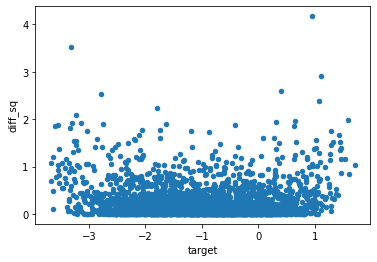

In [37]:
train_kf_df.plot(kind='scatter', x='target', y='diff_sq')

In [38]:
# 二乗誤差が2.0を超える列
thr_ = 2.0 
train_kf_df[train_kf_df['diff_sq'] > thr_]

,id,url_legal,license,excerpt,target,standard_error,kfold,bins_tg,bins_std,bins,pred,diff_sq
141,bcd734621,NaN,NaN,Midas was enjoying himself in his treasure-roo...,0.943021,0.537713,0,10,5,105,-1.100075,4.174241
304,f04e03fd8,NaN,NaN,"Jupiter, two hours high, was the herald of the...",-3.229761,0.551435,1,0,6,6,-1.783542,2.091551
990,afeb324bd,NaN,NaN,"On the morning of the 20th of March, a long se...",0.401053,0.481889,0,9,2,92,-1.206789,2.585155
1152,03b761fd9,https://simple.wikipedia.org/wiki/Larva,CC BY-SA 3.0 and GFDL,Probably the most widely accepted theory expla...,-2.778515,0.533111,2,1,5,15,-1.184370,2.541300
1628,4cf4a2fa3,https://kids.frontiersin.org/article/10.3389/f...,CC BY 4.0,"Although anyone, from kids to the elderly, can...",-1.802185,0.518239,1,4,4,44,-0.308248,2.231850
1944,04ade0eb2,NaN,NaN,"While I was hailing the brig, I spied a tract ...",-3.315282,0.544735,2,0,6,6,-1.439514,3.518508
2124,76f92b721,NaN,NaN,"The biggest desert in the world is in Africa, ...",1.103341,0.553751,2,10,6,106,-0.602162,2.908743
2586,551e0fc0b,https://www.commonlit.org/texts/sweet-difficul...,CC BY-NC-SA 2.0,"""Hey, I'm Ashley,"" said a dark-haired girl at ...",1.070988,0.553791,4,10,6,106,-0.475313,2.391045


In [39]:
# 二乗誤差が2.0を超える文章
thr_ = 2.0 
tmp_df = train_kf_df[train_kf_df['diff_sq'] > thr_].copy()
for i in tmp_df.index:
  print(tmp_df.loc[i].target)
  #print(tmp_df.loc[i].standard_error)
  print(tmp_df.loc[i].pred)
  print(tmp_df.loc[i].excerpt)
  print('--------------------------')

0.943020903
-1.100075125694275
Midas was enjoying himself in his treasure-room, one day, as usual, when he perceived a shadow fall over the heaps of gold; and, looking suddenly up, what should he behold but the figure of a stranger, standing in the bright and narrow sunbeam! It was a young man, with a cheerful and ruddy face. Whether it was that the imagination of King Midas threw a yellow tinge over everything, or whatever the cause might be, he could not help fancying that the smile with which the stranger regarded him had a kind of golden radiance in it. Certainly, although his figure intercepted the sunshine, there was now a brighter gleam upon all the piled-up treasures than before. Even the remotest corners had their share of it, and were lighted up, when the stranger smiled, as with tips of flame and sparkles of fire.
--------------------------
-3.229761439
-1.7835419178009033
Jupiter, two hours high, was the herald of the day; the Pleiades, just above the horizon, shed their sw

In [40]:
# validation再実行_予測結果取得_sign
all_predictions_sign = np.zeros(len(train_kf_df)) # 推論結果について、「fold　× 推論df」のzero行列で枠を作る

for fold_ in sorted(train_kf_df['kfold'].unique()):
    model_path = UPLOAD_DIR/f"sign_model_{fold_ + 1}.pth" # 対応するモデルを読む
    print(f"\nUsing {model_path}")

    val_idx = train_kf_df['kfold'] == fold_
    val_df = train_kf_df[val_idx]
    val_dataset = LitDataset(val_df, inference_only=True) # TestのDataset(何で、もう一回作るのだろう？)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE,
                          drop_last=False, shuffle=False, num_workers=2) # TestのDataLoader

    model = LitModel()
    model.load_state_dict(torch.load(model_path))    # 対応するモデルから、重みを読み込む
    model.to(DEVICE) # モデルをDEVICEへぶち込む

    all_predictions_sign[val_idx] = predict(model, val_loader) # 推論結果行列の対象列に、推論結果を入力(以後、繰り返し)

    del model
    gc.collect()



Using /content/model/sign_model_1.pth


Some weights of the model checkpoint at /content/clrp-pre-trained/clrp_roberta_large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at /content/clrp-pre-trained/clrp_roberta_large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN thi


Using /content/model/sign_model_2.pth


Some weights of the model checkpoint at /content/clrp-pre-trained/clrp_roberta_large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at /content/clrp-pre-trained/clrp_roberta_large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN thi


Using /content/model/sign_model_3.pth


Some weights of the model checkpoint at /content/clrp-pre-trained/clrp_roberta_large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at /content/clrp-pre-trained/clrp_roberta_large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN thi


Using /content/model/sign_model_4.pth


Some weights of the model checkpoint at /content/clrp-pre-trained/clrp_roberta_large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at /content/clrp-pre-trained/clrp_roberta_large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN thi


Using /content/model/sign_model_5.pth


Some weights of the model checkpoint at /content/clrp-pre-trained/clrp_roberta_large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at /content/clrp-pre-trained/clrp_roberta_large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN thi

In [41]:
np.sqrt(mean_squared_error(train_kf_df.target.values, all_predictions_sign))

0.5274277946314995

In [42]:
train_kf_df['pred_sign'] = all_predictions_sign
train_kf_df['diff_sq_sign'] = (train_kf_df['target'] - train_kf_df['pred_sign'])**2

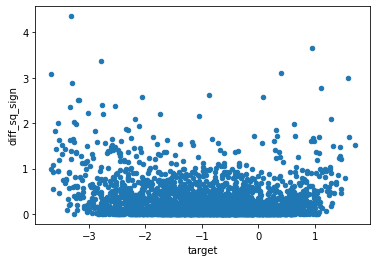

In [43]:
train_kf_df.plot(kind='scatter', x='target', y='diff_sq_sign')

In [44]:
# 二乗誤差が2.0を超えるレコード
thr_ = 2.0 
train_kf_df[train_kf_df['diff_sq_sign'] > thr_]

,id,url_legal,license,excerpt,target,standard_error,kfold,bins_tg,bins_std,bins,pred,diff_sq,pred_sign,diff_sq_sign
135,f317805ab,NaN,NaN,In the great square the boldest among the boys...,-1.736831,0.522754,0,4,5,45,-0.470745,1.602973,-0.250195,2.210086
141,bcd734621,NaN,NaN,Midas was enjoying himself in his treasure-roo...,0.943021,0.537713,0,10,5,105,-1.100075,4.174241,-0.969469,3.657618
181,804db3e6f,NaN,NaN,"I want now to tell you, gentlemen, whether you...",-3.182093,0.560802,4,1,7,17,-2.185042,0.994111,-1.599368,2.505019
333,ece951891,NaN,NaN,The power of Association is admitted by everyo...,-3.008131,0.646907,4,1,11,111,-1.981906,1.053138,-1.515740,2.227230
570,eb57cde1c,NaN,NaN,History in its broadest aspect is a record of ...,-2.186442,0.535444,4,3,5,35,-0.937928,1.558786,-0.738248,2.097264
637,b3899a2ee,NaN,NaN,One day Bessie was at her aunt's house when th...,-0.881504,0.509861,0,6,4,64,0.433424,1.729036,0.734903,2.612770
655,85a975cc1,https://kids.frontiersin.org/article/10.3389/f...,CC BY 4.0,The short-term effects of cannabis on the brai...,-1.046528,0.473312,3,5,2,52,-0.084968,0.924597,0.419230,2.148444
990,afeb324bd,NaN,NaN,"On the morning of the 20th of March, a long se...",0.401053,0.481889,0,9,2,92,-1.206789,2.585155,-1.358846,3.097243
1152,03b761fd9,https://simple.wikipedia.org/wiki/Larva,CC BY-SA 3.0 and GFDL,Probably the most widely accepted theory expla...,-2.778515,0.533111,2,1,5,15,-1.184370,2.541300,-0.944889,3.362185
1314,85b41606e,NaN,NaN,"As soon as the plate is dry, a positive cliché...",-3.543987,0.609348,3,0,9,9,-2.177368,1.867648,-2.128131,2.004650


In [45]:
# 二乗誤差が2.0を超える文章
thr_ = 2.0 
tmp_df = train_kf_df[train_kf_df['diff_sq_sign'] > thr_].copy()
for i in tmp_df.index:
  print(tmp_df.loc[i].target)
  #print(tmp_df.loc[i].standard_error)
  print(tmp_df.loc[i].pred)
  print(tmp_df.loc[i].excerpt)
  print('--------------------------')

-1.73683059
-0.47074493765830994
In the great square the boldest among the boys often tied their sledges to the country people's carts, and thus rode with them a good way. They went capitally. When they were in the midst of their playing there came a great sledge. It was painted quite white, and in it sat somebody wrapped in a rough, white fur, with a white, rough cap on his head. The sledge drove twice round the square, and Kay bound his little sledge to it, and so he drove on with it. It went faster and faster, straight into the next street. The man who drove turned round and nodded in a familiar way to Kay; it was as if they knew one another. Each time when Kay wanted to cast loose his little sledge, the stranger nodded again, and then Kay remained where he was, and thus they drove out at the town gate.
--------------------------
0.943020903
-1.100075125694275
Midas was enjoying himself in his treasure-room, one day, as usual, when he perceived a shadow fall over the heaps of gold; 

In [47]:
train_kf_df['pred_sign']

0      -0.190188
1      -0.806669
2      -1.742442
3      -1.508438
4      -0.761340
          ...   
2828   -1.296915
2829   -1.046332
2830   -2.259340
2831   -1.436424
2832   -0.412183
Name: pred_sign, Length: 2833, dtype: float64

In [48]:
train_kf_df['pred']

0      -0.294795
1      -0.690747
2      -1.797515
3      -1.509906
4      -0.726627
          ...   
2828   -1.225359
2829   -0.810944
2830   -2.793110
2831   -1.518603
2832   -0.406626
Name: pred, Length: 2833, dtype: float64

In [49]:
train_kf_df['target']

0      -0.279952
1       0.088148
2      -1.198192
3      -1.199957
4      -0.956118
          ...   
2828   -0.528836
2829   -1.188881
2830   -3.164808
2831   -1.979798
2832   -0.422689
Name: target, Length: 2833, dtype: float64

In [58]:
np.sqrt(mean_squared_error(train_kf_df.target.values, train_kf_df['pred']*0.8 + train_kf_df['pred_sign']*0.2))

0.4866724943135942

In [46]:
!pip install pulp

     |████████████████████████████████| 40.6 MB 54 kB/s 


In [60]:
def get_rmse(true, pred): 
  return np.sqrt(mean_squared_error(true, pred))

In [ ]:
target = train_kf_df.target.values
pred = train_kf_df['pred']*0.8 + train_kf_df['pred_sign']*0.2)

In [67]:
from sklearn.linear_model import LinearRegression

In [71]:
linear_model = LinearRegression(fit_intercept=False)
X = train_kf_df[['pred', 'pred_sign']]
y = train_kf_df.target.values

linear_model.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)

In [72]:
linear_model.coef_

array([0.86697646, 0.16458402])

In [74]:
weight = linear_model.coef_

target = train_kf_df.target.values
pred = train_kf_df['pred']*weight[0] + train_kf_df['pred_sign']*weight[1]

get_rmse(target, pred)

0.4846599419026998

In [77]:
dir_ = '/content/drive/MyDrive/Colab_Files/kaggle/commonlit/98_model_inf/057-051-train-08-02'
train_kf_df['pred'].to_csv(f'{dir_}/{EX_NO}_oof_target.csv')
train_kf_df['pred_sign'].to_csv(f'{dir_}/{EX_NO}_oof_sign.csv')

In [76]:
dir_

'/content/drive/MyDrive/Colab_Files/kaggle/commonlit/98_model_inf/057-051-train-08-02'